# ◆ 이상값 탐색 및 처리 실습

## 1. 필요 라이브러리 import

In [1]:
import random # 의사 난수 생성 package
import pandas as pd # pandas package
import numpy as np # numpy package : np.nan 이용 결측값 생성
import scipy.stats as stats
import matplotlib.pyplot as plt # matplotlib 시각화 패키지
%matplotlib inline
import seaborn as sns # seaborn 시각화 패키지

# os에 따른 Font 깨짐 제거를 위해 Font 지정
import os
if os.name == 'nt' : #Windows OS
    font_family = "Malgun Gothic"
else: # MAC OS
    font_family = "AppleGothic"
    
# - 값이 깨지는 문제 해결을 위해 파라미터값 설정
sns.set(font = font_family, rc = {"axes.unicode_minus" : False})

## 2. Z검정(Z-Test)을 이용한 이상값 처리

1) 데이터 생성

In [5]:
# 3000개의 랜덤 데이터 생성
np_data = np.random.randint(1, 100, size = 3000)
data = list(np_data)

In [6]:
data[0:2]

[11, 90]

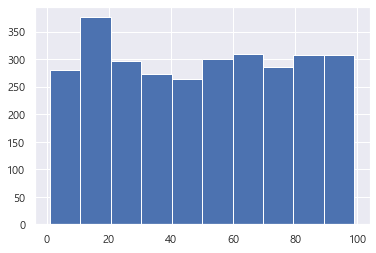

In [7]:
# 히스토그램으로 생성된 데이터 분포 확인
plt.hist(data)
plt.show()

49.70366666666666
28.753675473271624


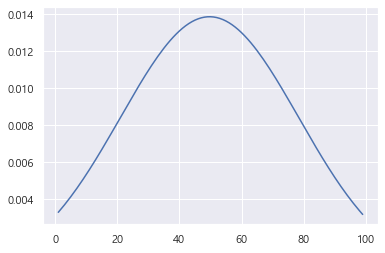

In [8]:
# Data의 정규분포 확인
data_mean = np.mean(data)
data_std = np.std(data)

print(data_mean)
print(data_std)

# 확률 밀도 함수 생성
pdf = stats.norm.pdf(np.sort(data), data_mean, data_std)

plt.figure()
plt.plot(np.sort(data), pdf)

1.1960802718628352e-16
1.0


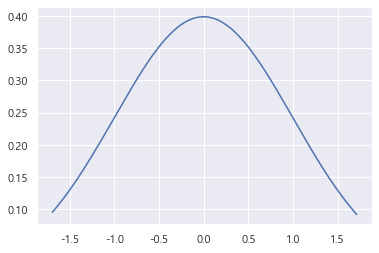

In [9]:
# 표준정규분포(Z분포)로 변환
std_list = []

for i in data:
    z = (i - data_mean) / data_std
    std_list.append(z)
    
ol_data_mean = np.mean(std_list)
ol_data_std = np.std(std_list)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(std_list), 
                       ol_data_mean, ol_data_std)

plt.figure()
plt.plot(np.sort(std_list), ol_pdf)

2) 데이터셋에 이상값 추가

49.830232558139535
29.024758871016786


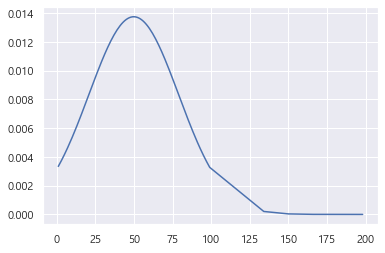

In [10]:
# 이상값 추가

ol_data = data.copy()
ol_no = 10

for i in range(ol_no):
    rand_no = random.randint(0, len(data))
    ol_data.insert(rand_no, ol_data[rand_no]*2) # 이상값 생성
    
# 이상값이 추가된 데이터의 정규분포도
ol_data_mean = np.mean(ol_data)
ol_data_std = np.std(ol_data)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(ol_data),
                       ol_data_mean, ol_data_std)

plt.figure()
plt.plot(np.sort(ol_data), ol_pdf)

-7.081821286645516e-18
1.0


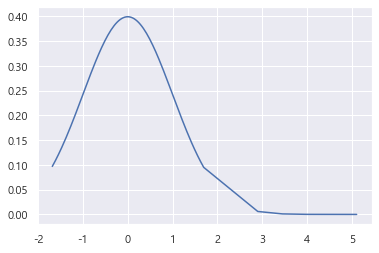

In [11]:
# 이상값 추가된 데이터의 표준화

ol_std_list = []

for i in ol_data:
    z = (i - ol_data_mean) / ol_data_std
    ol_std_list.append(z)
    
ol_st_data_mean = np.mean(ol_std_list)
ol_st_data_std = np.std(ol_std_list)

print(ol_st_data_mean)
print(ol_st_data_std)

ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list), 
                           ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

3) Z값의 2가 넘어 가는 데이터 삭제

In [13]:
# 전체라인수 확인
len(ol_std_list)

3010

In [15]:
# -2 ~ 2 범위 벗어나면 이상값으로 제거

for i in ol_std_list :
    z = i
    if z > 2:
        ol_std_list.remove(z)
    if z < -2:
        ol_std_list.remove(z)

In [16]:
# 이상값 제거 후 라인수
len(ol_std_list)

3006

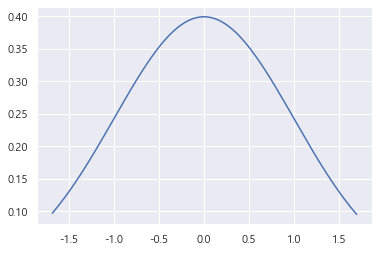

In [17]:
# 이상값 제거 후 표준정규분포 확인
ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list), ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

## 3. 사분위수 범위로 이상값 삭제

1) 이상값 데이터 생성

In [19]:
# 이상값 데이터 생성
boxdata = pd.DataFrame(np.random.randn(100, 3), columns=["A열", "B열", "C열"])

In [20]:
boxdata.head()

,A열,B열,C열
0,-0.552079,-0.189754,-0.866381
1,0.501795,0.160356,0.241326
2,-1.346939,1.214430,-1.163665
3,1.353653,-0.429304,-1.328388
4,0.550489,-0.375096,1.697242


2) 이상값 데이터 확인

In [21]:
# 기술 통계 정보로 pencentile 확인
boxdata.describe()

,A열,B열,C열
count,100.000000,100.000000,100.000000
mean,0.024144,0.015723,-0.010642
std,0.912516,1.075067,1.031242
min,-2.193918,-3.449850,-3.181727
25%,-0.591674,-0.441153,-0.681022
50%,0.014581,0.049953,-0.013704
75%,0.614905,0.719632,0.605351
max,2.300587,2.674031,2.471152


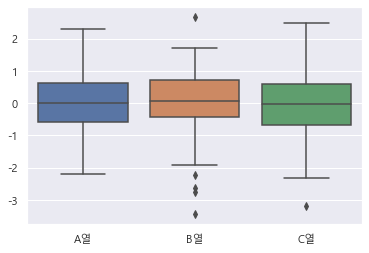

In [22]:
# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

3) 이상값 확인

In [23]:
# 이상값 계산하는 함수
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [24]:
# 함수를 사용해서 이상값 확ㅇ니
outlier_idx = get_outlier(df=boxdata, column='B열', weight=1.5)

In [25]:
outlier_idx

Int64Index([17, 71, 77, 89, 90], dtype='int64')

In [26]:
# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

In [27]:
boxdata.shape

(95, 3)

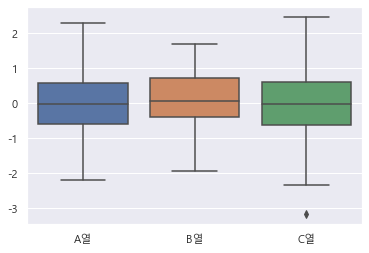

In [28]:
# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

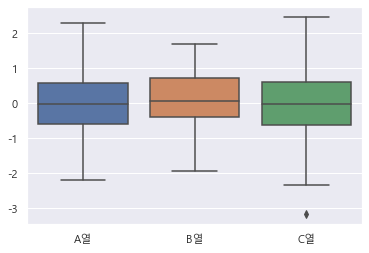

In [29]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='A열', weight=1.5)

outlier_idx

# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

boxdata.shape

# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

In [30]:
boxdata.shape

(95, 3)